In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib as mpl

import requests
import datetime
import copy
import math
import pickle
from tqdm.auto import tqdm
from datetime import timedelta, date
import time
import os
import numbers

import cel_utils.disk_utils as du

import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd

from jax import random
import numpyro
import numpyro.distributions as dist

import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc
import scenario_generator.utils as u

from mechafil.sim import run_simple_sim
from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, \
    get_cum_capped_qa_power, setup_spacescope
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df, \
    network_time, cum_baseline_reward, compute_baseline_power_array, \
    get_cum_capped_rb_power
from mechafil.supply import forecast_circulating_supply_df
from mechafil.constants import EIB, PIB
import pystarboard.data

## NOTE: This code uses mechaFIL in a non-standard way. To reproduce the results,
#   the `update_policy` branch of mechaFIL needs to be used - not the main branch.
#   https://github.com/protocol/filecoin-mecha-twin/tree/update_policy
# This comment is relevant as of 16-Sep-2023.

In [4]:
NDEVICES = 2 
numpyro.set_host_device_count(NDEVICES)

# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

# set the simulation start date
today = datetime.date(2023, 9, 10) 
DATA_LAG_DAYS = 0
current_date = today - datetime.timedelta(days=(DATA_LAG_DAYS))
current_day = (current_date - datetime.date(2020, 10, 15)).days

start_date = datetime.date(2023, 8, 1)  # reduce locking bias by starting simulation close to current date
start_day = (start_date - datetime.date(2020, 10, 15)).days

# Forecast timeframe
forecast_lenght = int(365*5)
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)

2023-08-01
2023-09-10
2028-09-08


In [5]:
offline_folder = 'offline_info'
results_folder = 'results'
os.makedirs(offline_folder, exist_ok=True)
os.makedirs(results_folder, exist_ok=True)

# helpful constants
TIB = 2 ** 40
GIB = 2 ** 30

SECTOR_SIZE = 32 * GIB
EPOCH_PER_DAY = 2880
MEGA = 1_000_000

setup_spacescope('/Users/kiran/code/auth/kiran_spacescope_auth.json')
pystarboard.data.setup_spacescope('/Users/kiran/code/auth/kiran_spacescope_auth.json')

In [6]:
@du.cache_data(directory=offline_folder)
def download_historical_data():
    t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(start_date, current_date)
    t_hist_rr, hist_rr = u.get_historical_renewal_rate(start_date, current_date)
    t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(start_date, current_date)

    fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)
    sector_expiration_stats_offline = get_sector_expiration_stats(start_date, current_date,end_date)
    
    network_baseline = compute_baseline_power_array(start_date, end_date)
    zero_cum_capped_power = get_cum_capped_rb_power(start_date)

    dict_out = {
        't_rbp': t_hist_rbp,
        'hist_rbp': hist_rbp,
        't_rr': t_hist_rr,
        'historical_renewal_rate': hist_rr,
        't_fpr': t_hist_fpr,
        'historical_fpr': hist_fpr,
        'fil_stats_df': fil_stats_df,
        'sector_expiration_stats_offline': sector_expiration_stats_offline,
        'network_baseline': network_baseline,
        'zero_cum_capped_power': zero_cum_capped_power
    }
    
    return dict_out
    
historical_data = download_historical_data()
globals().update(**historical_data)

In [38]:
## the main simulation library functions

def baseline_storage(epoch:float)->float:
    # Spec value:
    # BASELINE_B0 = 2.88888888 
    # The following value is required to match sentinel
    # to Reproduce the first baseline crossing in backtest.
    # It's also close to the value the starboard use: 2.77. 
    # !Someone should look more closely at this.
    BASELINE_B0 = 2.7636 
    BASELINE_R = np.log(2) / (2880*365) # 1_051_200 in eopchs
    EPOCH_PER_DAY = 2880
    return BASELINE_B0 * np.exp(BASELINE_R * epoch)

# find baseline crossings
def find_crossings(df:pd.DataFrame)->pd.DataFrame:
    xing = np.array([])
    for i in range(df.iter[-1]+1):
        df_i = df[df['iter'] == i]
        df_crossing = df_i[df_i.network_RBP.values/EIB < baseline]
        if len(df_crossing) > 0:
            xing_i = df_i[df_i.network_RBP.values/EIB < baseline].index[0]
            xing = np.append(xing,xing_i)
    return xing

def clip_all_powers(df_in):
    """
    'onboarded_power', 'cum_onboarded_power',
    'expire_scheduled_power', 'cum_expire_scheduled_power', 'renewed_power',
    'cum_renewed_power', 'total_power', 'power_type', 'total_qa_power_eib'
    """
    df_out = df_in.copy()
    for c in df_out.columns:
        if 'power' in c and c != 'power_type':
#             df_out[c] = df_out[c].clip(lower=1e-4)
            df_out[c] = df_out[c].clip(lower=0)
    return df_out

# add ROI to trajectory
def add_generated_quantities(cil_rbp, duration=365)->pd.DataFrame:
    # add ROI to trajectory df
#     df['day_pledge_per_QAP'] = SECTOR_SIZE * df['day_locked_pledge'] / (df['day_onboarded_power_QAP'] + df['day_renewed_power_QAP'])
    cil_rbp['day_pledge_per_QAP'] = SECTOR_SIZE * (cil_rbp['day_locked_pledge']-cil_rbp['day_renewed_pledge'])/(cil_rbp['day_onboarded_power_QAP'])
    cil_rbp['day_rewards_per_sector'] = SECTOR_SIZE * cil_rbp.day_network_reward / cil_rbp.network_QAP
    cil_rbp['1y_return_per_sector'] = cil_rbp['day_rewards_per_sector'].rolling(365).sum().shift(-365+1).values.flatten()
    cil_rbp['1y_sector_roi'] = cil_rbp['1y_return_per_sector'] / cil_rbp['day_pledge_per_QAP']

    duration_yr = duration/365
    cil_rbp['duration_return_per_sector'] = cil_rbp['day_rewards_per_sector'].rolling(duration).sum().shift(-duration+1).values.flatten()
    cil_rbp['duration_sector_roi'] = cil_rbp['duration_return_per_sector'] / cil_rbp['day_pledge_per_QAP']
    cil_rbp['duration_roi_annualized'] = np.power(cil_rbp['duration_sector_roi'] + 1, 1/duration_yr) - 1
    return cil_rbp

def run_sim(
    rb_onboard_power_pred_IN, 
    renewal_rate_vec_pred_IN, 
    fil_plus_rate_pred_IN,
    duration=365, 
    cc_multiplier_fn = None,
    cc_multiplier_fn_kwargs = None,
    filp_multiplier_fn = None,
    filp_multiplier_fn_kwargs = None,
    qap_mode='basic', 
    intervention_config={},
    sector_expiration_stats_IN=sector_expiration_stats_offline
):
    # api for power-forecasting and circ-supply are slightly different
    renewal_rate_vec_IN = np.concatenate([historical_renewal_rate, renewal_rate_vec_pred_IN])    

    if sector_expiration_stats_IN is None:
        res = get_sector_expiration_stats(start_date, current_date,end_date)
    else:
        res = sector_expiration_stats_IN
    rb_known_scheduled_expire_vec = res[0]
    qa_known_scheduled_expire_vec = res[1]
    known_scheduled_pledge_release_full_vec = res[2]
    
    current_day_stats = fil_stats_df.iloc[-1]
    
    rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
    qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

    rb_power_df, qa_power_df = forecast_power_stats(
        rb_power_zero,
        qa_power_zero,
        rb_onboard_power_pred_IN,
        rb_known_scheduled_expire_vec,
        qa_known_scheduled_expire_vec,
        renewal_rate_vec_IN[-int(forecast_lenght):],
        fil_plus_rate_pred_IN,
        duration,
        forecast_lenght,
        fil_plus_m = 10,
        cc_multiplier_fn = cc_multiplier_fn,
        cc_multiplier_fn_kwargs = cc_multiplier_fn_kwargs,
        filp_multiplier_fn = filp_multiplier_fn,
        filp_multiplier_fn_kwargs = filp_multiplier_fn_kwargs,
        qap_method=qap_mode,
        intervention_config=intervention_config,
        fpr_hist_info=(t_fpr, historical_fpr)
    )

    ########## BUG FIX
    rb_power_df = clip_all_powers(rb_power_df)
    qa_power_df = clip_all_powers(qa_power_df)
    ##########
    rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
    qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0
        
    power_df = build_full_power_stats_df(
        fil_stats_df,
        rb_power_df,
        qa_power_df,
        start_date,
        current_date,
        end_date,
    )
    
    rb_total_power_eib = power_df["total_raw_power_eib"].values
    qa_total_power_eib = power_df["total_qa_power_eib"].values
    qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
    qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values

    vest_df = compute_vesting_trajectory_df(start_date, end_date)
    
    mint_df_rbpbase = compute_minting_trajectory_df(
        start_date,
        end_date,
        rb_total_power_eib,
        qa_total_power_eib,
        qa_day_onboarded_power_pib,
        qa_day_renewed_power_pib,
        minting_base = 'rbp'
    )
    
    start_day_stats = fil_stats_df.iloc[0]
    circ_supply_zero = start_day_stats["circulating_fil"]
    locked_fil_zero = start_day_stats["locked_fil"]
    burnt_fil_zero = start_day_stats["burnt_fil"]
    daily_burnt_fil = fil_stats_df["burnt_fil"].diff().mean()
    burnt_fil_vec = fil_stats_df["burnt_fil"].values

    cil_df_rbp = forecast_circulating_supply_df(
        start_date,
        current_date,
        end_date,
        circ_supply_zero,
        locked_fil_zero,
        daily_burnt_fil,
        duration,
        renewal_rate_vec_IN,
        burnt_fil_vec,
        vest_df,
        mint_df_rbpbase,
        known_scheduled_pledge_release_full_vec,
        fil_plus_rate=fil_plus_rate_pred_IN,
        intervention_config=intervention_config,
        fpr_hist_info=(t_fpr, historical_fpr)
    )
    
    rbp_roi = add_generated_quantities(cil_df_rbp, duration=duration)
    
    return_dict = {
        'power_df': power_df,
        'rb_power_df': rb_power_df,
        'qa_power_df': qa_power_df,
        'mint_df': mint_df_rbpbase,
        'rbp_roi': rbp_roi,
        'renewal_rate_vec': renewal_rate_vec_IN,
        'rb_onboard_power_pred': rb_onboard_power_pred_IN,
        'fil_plus_rate_pred': fil_plus_rate_pred_IN
    }
    
    return return_dict

In [22]:
median_rbp = np.median(hist_rbp[-30:])
median_rr = np.median(historical_renewal_rate[-30:])
median_fpr = np.median(historical_fpr[-30:])

In [23]:
# define different input scenarios
constant_median_scenario = {
    'name': 'Median',
    'rb_onboard_power': np.ones(forecast_lenght)*median_rbp,
    'renewal_rate': np.ones(forecast_lenght)*median_rr,
    'filplus_rate': np.ones(forecast_lenght)*median_fpr
}

# TODO: define other relevant scenarios, such as not onboarding between acceptance and policy implementation

onboarding_scenarios = [
    constant_median_scenario
]

In [27]:
# note that the input is *ADDITIONAL* multiplier on top of the 1x/10x - which is the current protocol
def const_2_5(): return 2.5
def const_5(): return 5
def const_1(): return 1
def const_2(): return 2
multiplier_cfgs = [
    {
        'name': '2.5x,10x',
        'cc_multiplier_fn': const_2_5,    # Implies CC/RD = 2.5x
        'cc_multiplier_fn_kwargs': {},
        'filp_multiplier_fn': const_1,  # implies FILP = 10x
        'filp_multiplier_fn_kwargs': {},
    },
    {
        'name': '5x, 10x',
        'cc_multiplier_fn': const_5,    # Implies CC/RD = 5x
        'cc_multiplier_fn_kwargs': {},
        'filp_multiplier_fn': const_1,  # implies FILP = 10x
        'filp_multiplier_fn_kwargs': {},
    },
    {
        'name': '5x,20x',
        'cc_multiplier_fn': const_5,    # Implies CC/RD = 5x
        'cc_multiplier_fn_kwargs': {},
        'filp_multiplier_fn': const_2,  # implies FILP = 20x
        'filp_multiplier_fn_kwargs': {},
    }
]

In [28]:
#intervention_date=datetime.date(2023,1,15)
intervention_date = current_date + timedelta(days=90)
num_days_shock_behavior = 360
avg_sector_duration = 360

qap_mode = 'tunable'

sim_vec = []
for multiplier_cfg in multiplier_cfgs:
    multiplier_cfg_in = copy.copy(multiplier_cfg)
    multiplier_cfg_in.pop('name')
    for onboarding_scenario in onboarding_scenarios:
        nn_append = '%s-%s' % (onboarding_scenario['name'], multiplier_cfg['name'])

        no_sdm = {
            'name': 'StatusQuo[%s]' % (nn_append,),      
            'rbp': copy.deepcopy(onboarding_scenario['rb_onboard_power']),
            'rr': copy.deepcopy(onboarding_scenario['renewal_rate']),
            'fpr': copy.deepcopy(onboarding_scenario['filplus_rate']),
            'kwargs':{
                'duration': avg_sector_duration, 
                'cc_multiplier_fn': multiplier_cfg_in['cc_multiplier_fn'],
                'cc_multiplier_fn_kwargs': multiplier_cfg_in['cc_multiplier_fn_kwargs'],
                'filp_multiplier_fn': multiplier_cfg_in['filp_multiplier_fn'],
                'filp_multiplier_fn_kwargs': multiplier_cfg_in['filp_multiplier_fn_kwargs'],
                'qap_mode':qap_mode,
                'intervention_config': {
                    'type': 'noop',
                    'num_days_shock_behavior': num_days_shock_behavior,
                    'intervention_date': intervention_date,
                    'simulation_start_date': current_date + datetime.timedelta(days=1),
                    'update_onboard_power_multiplier_before_intervention': False,
                    'update_onboard_power_multiplier_after_intervention': False,
                    'update_renew_power_multiplier_before_intervention': False,
                    'update_renew_power_multiplier_after_intervention': False
                }
            }
        }

        scenario_1a = {
            'name': '1A[%s]' % (nn_append,),  
            'rbp': copy.deepcopy(onboarding_scenario['rb_onboard_power']),
            'rr': copy.deepcopy(onboarding_scenario['renewal_rate']),
            'fpr': copy.deepcopy(onboarding_scenario['filplus_rate']),
            'kwargs':{
                'duration': avg_sector_duration, 
                'cc_multiplier_fn': multiplier_cfg_in['cc_multiplier_fn'],
                'cc_multiplier_fn_kwargs': multiplier_cfg_in['cc_multiplier_fn_kwargs'],
                'filp_multiplier_fn': multiplier_cfg_in['filp_multiplier_fn'],
                'filp_multiplier_fn_kwargs': multiplier_cfg_in['filp_multiplier_fn_kwargs'],
                'qap_mode':qap_mode,
                'intervention_config': {
                    'type': 'noop',
                    'num_days_shock_behavior': num_days_shock_behavior,
                    'intervention_date': intervention_date,
                    'simulation_start_date': current_date + datetime.timedelta(days=1),
                    'update_onboard_power_multiplier_before_intervention': False,
                    'update_onboard_power_multiplier_after_intervention': True,
                    'update_renew_power_multiplier_before_intervention': False,
                    'update_renew_power_multiplier_after_intervention': True
              }
          }
        }
        scenario_1b = {
            'name': '1B[%s]' % (nn_append,),  
            'rbp': copy.deepcopy(onboarding_scenario['rb_onboard_power']),
            'rr': copy.deepcopy(onboarding_scenario['renewal_rate']),
            'fpr': copy.deepcopy(onboarding_scenario['filplus_rate']),
            'kwargs':{
                'duration': avg_sector_duration, 
                'cc_multiplier_fn': multiplier_cfg_in['cc_multiplier_fn'],
                'cc_multiplier_fn_kwargs': multiplier_cfg_in['cc_multiplier_fn_kwargs'],
                'filp_multiplier_fn': multiplier_cfg_in['filp_multiplier_fn'],
                'filp_multiplier_fn_kwargs': multiplier_cfg_in['filp_multiplier_fn_kwargs'],
                'qap_mode':qap_mode,
                'intervention_config': {
                    'type': 'cc_early_renewal',
                    'num_days_shock_behavior': num_days_shock_behavior,
                    'intervention_date': intervention_date,
                    'simulation_start_date': current_date + datetime.timedelta(days=1),
                    'update_onboard_power_multiplier_before_intervention': False,
                    'update_onboard_power_multiplier_after_intervention': True,
                    'update_renew_power_multiplier_before_intervention': False,
                    'update_renew_power_multiplier_after_intervention': True
                }
            }
        }
        scenario_2a = {
            'name': '2A[%s]' % (nn_append,),
            'rbp': copy.deepcopy(onboarding_scenario['rb_onboard_power']),
            'rr': copy.deepcopy(onboarding_scenario['renewal_rate']),
            'fpr': copy.deepcopy(onboarding_scenario['filplus_rate']),
            'kwargs':{
                'duration': avg_sector_duration, 
                'cc_multiplier_fn': multiplier_cfg_in['cc_multiplier_fn'],
                'cc_multiplier_fn_kwargs': multiplier_cfg_in['cc_multiplier_fn_kwargs'],
                'filp_multiplier_fn': multiplier_cfg_in['filp_multiplier_fn'],
                'filp_multiplier_fn_kwargs': multiplier_cfg_in['filp_multiplier_fn_kwargs'],
                'qap_mode':qap_mode,
                'intervention_config': {
                    'type': 'noop',
                    'num_days_shock_behavior': num_days_shock_behavior,
                    'intervention_date': intervention_date,
                    'simulation_start_date': current_date + datetime.timedelta(days=1),
                    'update_onboard_power_multiplier_before_intervention': False,
                    'update_onboard_power_multiplier_after_intervention': True,
                    'update_renew_power_multiplier_before_intervention': False,
                    'update_renew_power_multiplier_after_intervention': False
                }
            }
        }
        scenario_2b = {
            'name': '2B[%s]' % (nn_append,),
            'rbp': copy.deepcopy(onboarding_scenario['rb_onboard_power']),
            'rr': copy.deepcopy(onboarding_scenario['renewal_rate']),
            'fpr': copy.deepcopy(onboarding_scenario['filplus_rate']),
            'kwargs':{
                'duration': avg_sector_duration, 
                'cc_multiplier_fn': multiplier_cfg_in['cc_multiplier_fn'],
                'cc_multiplier_fn_kwargs': multiplier_cfg_in['cc_multiplier_fn_kwargs'],
                'filp_multiplier_fn': multiplier_cfg_in['filp_multiplier_fn'],
                'filp_multiplier_fn_kwargs': multiplier_cfg_in['filp_multiplier_fn_kwargs'],
                'qap_mode':qap_mode,
                'intervention_config': {
                    'type': 'cc_early_terminate_and_onboard',
                    'num_days_shock_behavior': num_days_shock_behavior,
                    'cc_reonboard_time_days': 60,
                    'intervention_date': intervention_date,
                    'simulation_start_date': current_date + datetime.timedelta(days=1),
                    'update_onboard_power_multiplier_before_intervention': False,
                    'update_onboard_power_multiplier_after_intervention': True,
                    'update_renew_power_multiplier_before_intervention': False,
                    'update_renew_power_multiplier_after_intervention': False
                }
            }
        }
        sim_vec.append(copy.deepcopy(no_sdm))
        sim_vec.append(copy.deepcopy(scenario_1a))
        sim_vec.append(copy.deepcopy(scenario_1b))
        sim_vec.append(copy.deepcopy(scenario_2a))
        sim_vec.append(copy.deepcopy(scenario_2b))

In [30]:
@du.cache_data(directory=offline_folder)
def exec_sims():
    results = {}
    for sim in tqdm(sim_vec):
        kwargs = sim['kwargs']
        return_dict = run_sim(sim['rbp'], sim['rr'], sim['fpr'], **kwargs)
        results[sim['name']] = return_dict
    return {'results': results}
results = exec_sims()
globals().update(**results)

  0%|          | 0/15 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


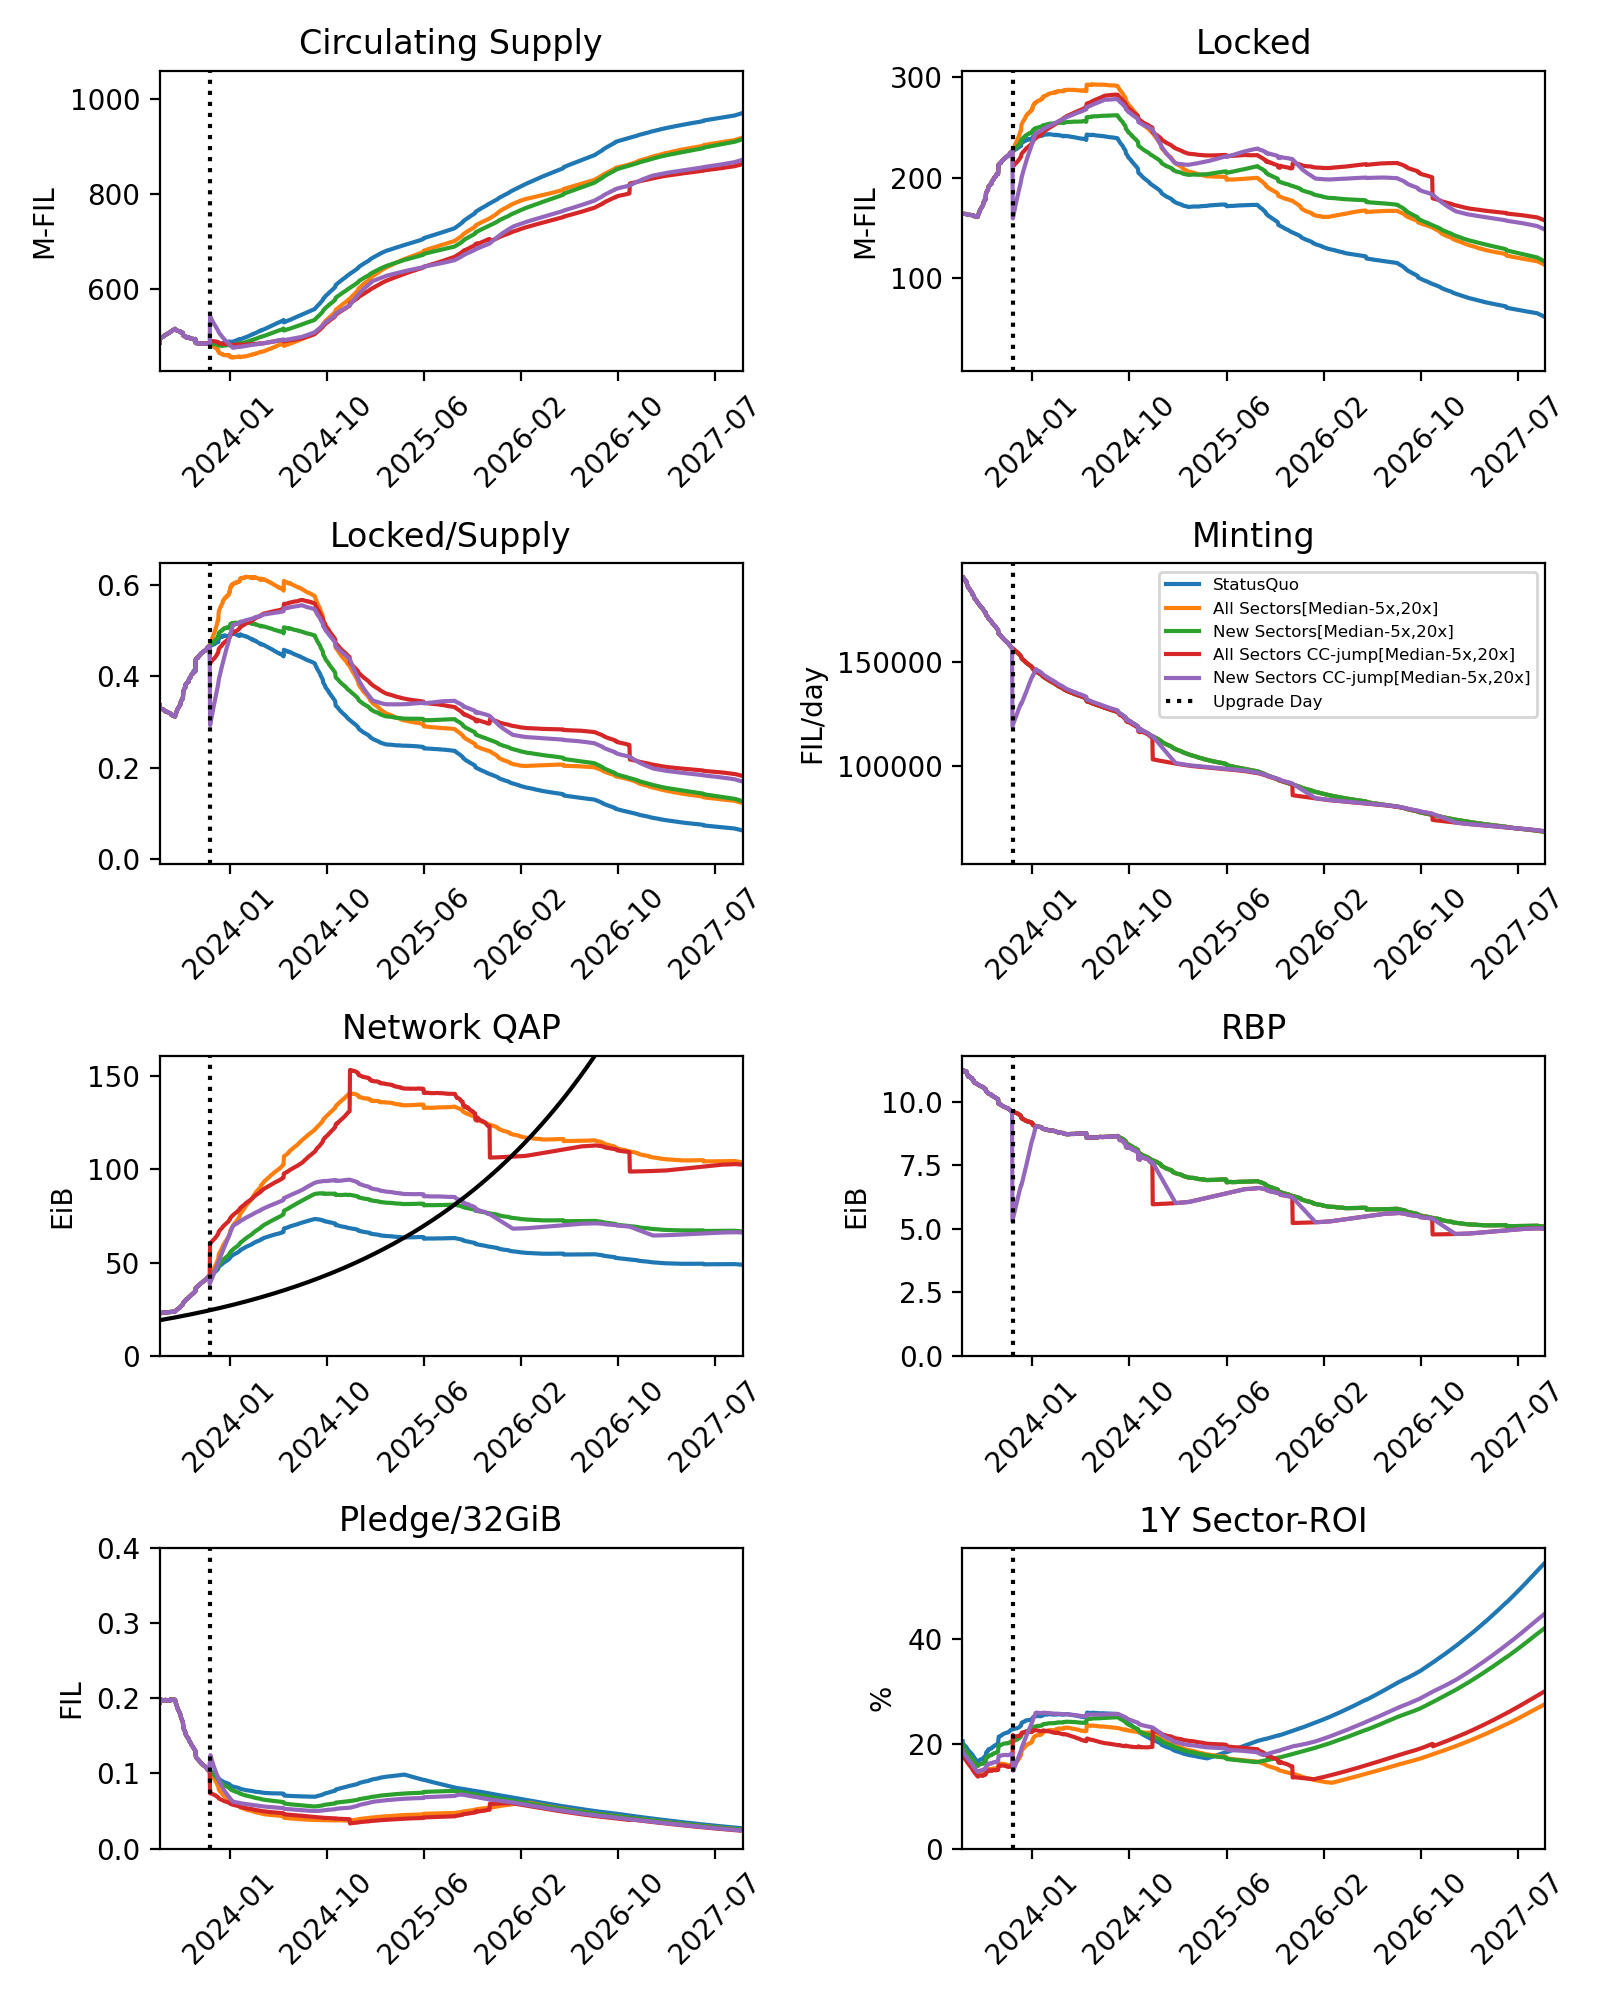

In [46]:
plt_statusquo = True
plt_a = True
plt_b = True
plt_cfg = 'Median-5x,20x'  # can be: 'Median-2.5x,10x', 'Median-5x, 10x', 'Median-5x,20x'

plt.figure(figsize=(8,10))
if plt_statusquo:
    no_sdm = results['StatusQuo[%s]' % (plt_cfg,)]['rbp_roi']
if plt_a:
    r1a = results['1A[%s]' % (plt_cfg,)]['rbp_roi']
    r2a = results['2A[%s]' % (plt_cfg,)]['rbp_roi']
if plt_b:
    r1b = results['1B[%s]' % (plt_cfg,)]['rbp_roi']
    r2b = results['2B[%s]' % (plt_cfg,)]['rbp_roi']
        
min_time = no_sdm['date'].iloc[0]
max_time = current_date + datetime.timedelta(days=365*4)
        
plt.subplot(4,2,1)
if plt_statusquo:
    p0, = plt.plot(no_sdm['date'], no_sdm['circ_supply'] / MEGA, label='StatusQuo')
if plt_a:
    p1, = plt.plot(r1a['date'], r1a['circ_supply'] / MEGA, label='All Sectors[%s]' % (plt_cfg, ))
    p2, = plt.plot(r2a['date'], r2a['circ_supply'] / MEGA, label='New Sectors[%s]' % (plt_cfg, ))
if plt_b:
    p3, = plt.plot(r1b['date'], r1b['circ_supply'] / MEGA, label='All Sectors CC-jump[%s]' % (plt_cfg, ))
    p4, = plt.plot(r2b['date'], r2b['circ_supply'] / MEGA, label='New Sectors CC-jump[%s]' % (plt_cfg, ))

p5 = plt.axvline(intervention_date, linestyle=':', color='k', label='Upgrade Day')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')
plt.ylabel('M-FIL')
plt.title('Circulating Supply')
# plt.legend(fontsize=6)
# plt.rc('legend', fontsize = 7)
# l1 = plt.legend([p0,p1,p2], ["No-SDM", "AllSectors", "NewSectors"], loc=0)
# l2 = plt.legend([p3,p4,p5], ["All Sectors CC-jump", "New Sectors CC-jump", "SDM Upgrade Day"], loc=4)
# plt.gca().add_artist(l1)

ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)


plt.subplot(4,2,2)
if plt_statusquo:
    plt.plot(no_sdm['date'], no_sdm['network_locked']/MEGA, label='StatusQuo')
if plt_a:
    p1 = plt.plot(r1a['date'], r1a['network_locked']/MEGA)
    p2 = plt.plot(r2a['date'], r2a['network_locked']/MEGA)
if plt_b:
    p1 = plt.plot(r1b['date'], r1b['network_locked']/MEGA)
    p2 = plt.plot(r2b['date'], r2b['network_locked']/MEGA)
plt.axvline(intervention_date, linestyle=':', color='k')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')
plt.title('Locked')
plt.ylabel('M-FIL')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)

plt.subplot(4,2,3)
if plt_statusquo:
    plt.plot(no_sdm['date'], (no_sdm['network_locked']/no_sdm['circ_supply']), label='StatusQuo')
if plt_a:
    p1 = plt.plot(r1a['date'], (r1a['network_locked']/r1a['circ_supply']))
    p2 = plt.plot(r2a['date'], (r2a['network_locked']/r2a['circ_supply']))
if plt_b:
    p1 = plt.plot(r1b['date'], (r1b['network_locked']/r1b['circ_supply']))
    p2 = plt.plot(r2b['date'], (r2b['network_locked']/r2b['circ_supply']))
plt.axvline(intervention_date, linestyle=':', color='k')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')
plt.title('Locked/Supply')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)

k = 'day_network_reward'; scale=1; ylab_str='FIL/day'; title_str='Minting'
plt.subplot(4,2,4)
if plt_statusquo:
    plt.plot(no_sdm['date'], no_sdm[k]/scale, label='StatusQuo')
if plt_a:
    p1 = plt.plot(r1a['date'], r1a[k]/scale, label='All Sectors[%s]' % (plt_cfg, ))
    p2 = plt.plot(r2a['date'], r2a[k]/scale, label='New Sectors[%s]' % (plt_cfg, ))
if plt_b:
    p1 = plt.plot(r1b['date'], r1b[k]/scale, label='All Sectors CC-jump[%s]' % (plt_cfg, ))
    p2 = plt.plot(r2b['date'], r2b[k]/scale, label='New Sectors CC-jump[%s]' % (plt_cfg, ))
plt.axvline(intervention_date, linestyle=':', color='k', label='Upgrade Day')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')
plt.title(title_str)
plt.ylabel(ylab_str)
plt.legend(fontsize=6)
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)

plt.subplot(4,2,5)
if plt_statusquo:
    plt.plot(no_sdm['date'], no_sdm['network_QAP'] / EIB, label='StatusQuo')
if plt_a:
    p1 = plt.plot(r1a['date'], r1a['network_QAP']/EIB, label='All Sectors[%s]' % (plt_cfg, ))
    p2 = plt.plot(r2a['date'], r2a['network_QAP']/EIB, label='New Sectors[%s]' % (plt_cfg, ))
if plt_b:
    p1 = plt.plot(r1b['date'], r1b['network_QAP']/EIB, label='All Sectors CC-jump[%s]' % (plt_cfg, ))
    p2 = plt.plot(r2b['date'], r2b['network_QAP']/EIB, label='New Sectors CC-jump[%s]' % (plt_cfg, ))
plt.axvline(intervention_date, linestyle=':', color='k')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')
plt.title('Network QAP')
plt.ylabel('EiB')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)
max_qap = np.max([no_sdm[no_sdm['date']<=max_time]['network_QAP'],
                  r1a[r1a['date']<=max_time]['network_QAP'],
                  r2a[r2a['date']<=max_time]['network_QAP'],
                  r1b[r1b['date']<=max_time]['network_QAP'],
                  r2b[r2b['date']<=max_time]['network_QAP']])
max_qap_eib = max_qap / EIB
plt.ylim(0, max_qap_eib*1.05)
# plt.legend(fontsize=8)
baseline = baseline_storage(no_sdm.days * EPOCH_PER_DAY)
plt.plot(no_sdm['date'], baseline, color='k')


k = 'network_RBP'; title_str='RBP'; scale=EIB; ylab_str = 'EiB'
plt.subplot(4,2,6)
if plt_statusquo:
    plt.plot(no_sdm['date'], no_sdm[k]/scale, label='StatusQuo')
if plt_a:
    p1 = plt.plot(r1a['date'], r1a[k]/scale)
    p2 = plt.plot(r2a['date'], r2a[k]/scale)
if plt_b:
    p1 = plt.plot(r1b['date'], r1b[k]/scale)
    p2 = plt.plot(r2b['date'], r2b[k]/scale)
plt.axvline(intervention_date, linestyle=':', color='k')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')

plt.title(title_str)
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)
max_v = np.concatenate([no_sdm[no_sdm['date']<=max_time][k].values,
                r1a[r1a['date']<=max_time][k].values,
                r2a[r2a['date']<=max_time][k].values,
                r1b[r1b['date']<=max_time][k].values,
                r2b[r2b['date']<=max_time][k].values])
mv = np.nanmax(max_v[max_v != np.inf])
plt.ylim(0, mv*1.05/scale)
plt.ylabel(ylab_str)

plt.subplot(4,2,7)
k='day_pledge_per_QAP'
if plt_statusquo:
    plt.plot(no_sdm['date'].iloc[1:], no_sdm[k].iloc[1:], label='StatusQuo')
if plt_a:
    p1 = plt.plot(r1a['date'].iloc[1:], r1a[k].iloc[1:])
    p2 = plt.plot(r2a['date'].iloc[1:], r2a[k].iloc[1:])
if plt_b:
    p1 = plt.plot(r1b['date'].iloc[1:], r1b[k].iloc[1:])
    p2 = plt.plot(r2b['date'].iloc[1:], r2b[k].iloc[1:])

plt.axvline(intervention_date, linestyle=':', color='k')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')
plt.title('Pledge/32GiB')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)
max_v = np.concatenate([no_sdm[no_sdm['date']<=max_time][k].values,
                r1a[r1a['date']<=max_time][k].values,
                r2a[r2a['date']<=max_time][k].values,
                r1b[r1b['date']<=max_time][k].values,
                r2b[r2b['date']<=max_time][k].values])
mv = np.nanmax(max_v[max_v != np.inf])
plt.ylim(0, 0.4)
plt.ylabel('FIL')

plt.subplot(4,2,8)
if plt_statusquo:
    plt.plot(no_sdm['date'], no_sdm['1y_sector_roi']*100)
if plt_a:
    p1 = plt.plot(r1a['date'], r1a['1y_sector_roi']*100)
    p2 = plt.plot(r2a['date'], r2a['1y_sector_roi']*100)
if plt_b:
    p1 = plt.plot(r1b['date'], r1b['1y_sector_roi']*100)
    p2 = plt.plot(r2b['date'], r2b['1y_sector_roi']*100)

plt.axvline(intervention_date, linestyle=':', color='k')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')

plt.title('1Y Sector-ROI')
plt.ylabel('%')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)
max_v = np.concatenate([no_sdm[no_sdm['date']<=max_time]['1y_sector_roi'].values,
                r1a[r1a['date']<=max_time]['1y_sector_roi'].values,
                r2a[r2a['date']<=max_time]['1y_sector_roi'].values,
                r1b[r1b['date']<=max_time]['1y_sector_roi'].values,
                r2b[r2b['date']<=max_time]['1y_sector_roi'].values])
mv = np.nanmax(max_v[max_v != np.inf])
plt.ylim(0, mv*1.05*100)

plt.tight_layout()
plt.savefig(os.path.join(results_folder, 'macro_%s.png' % (plt_cfg,)))

In [47]:
scenariocfg2str = {
    '1A': 'All-Sectors',
    '1B': 'New-Sectors',
    '2A': 'All-Sectors CC-Jump',
    '2B': 'New-Sectors CC-Jump'
}

<IPython.core.display.Javascript object>


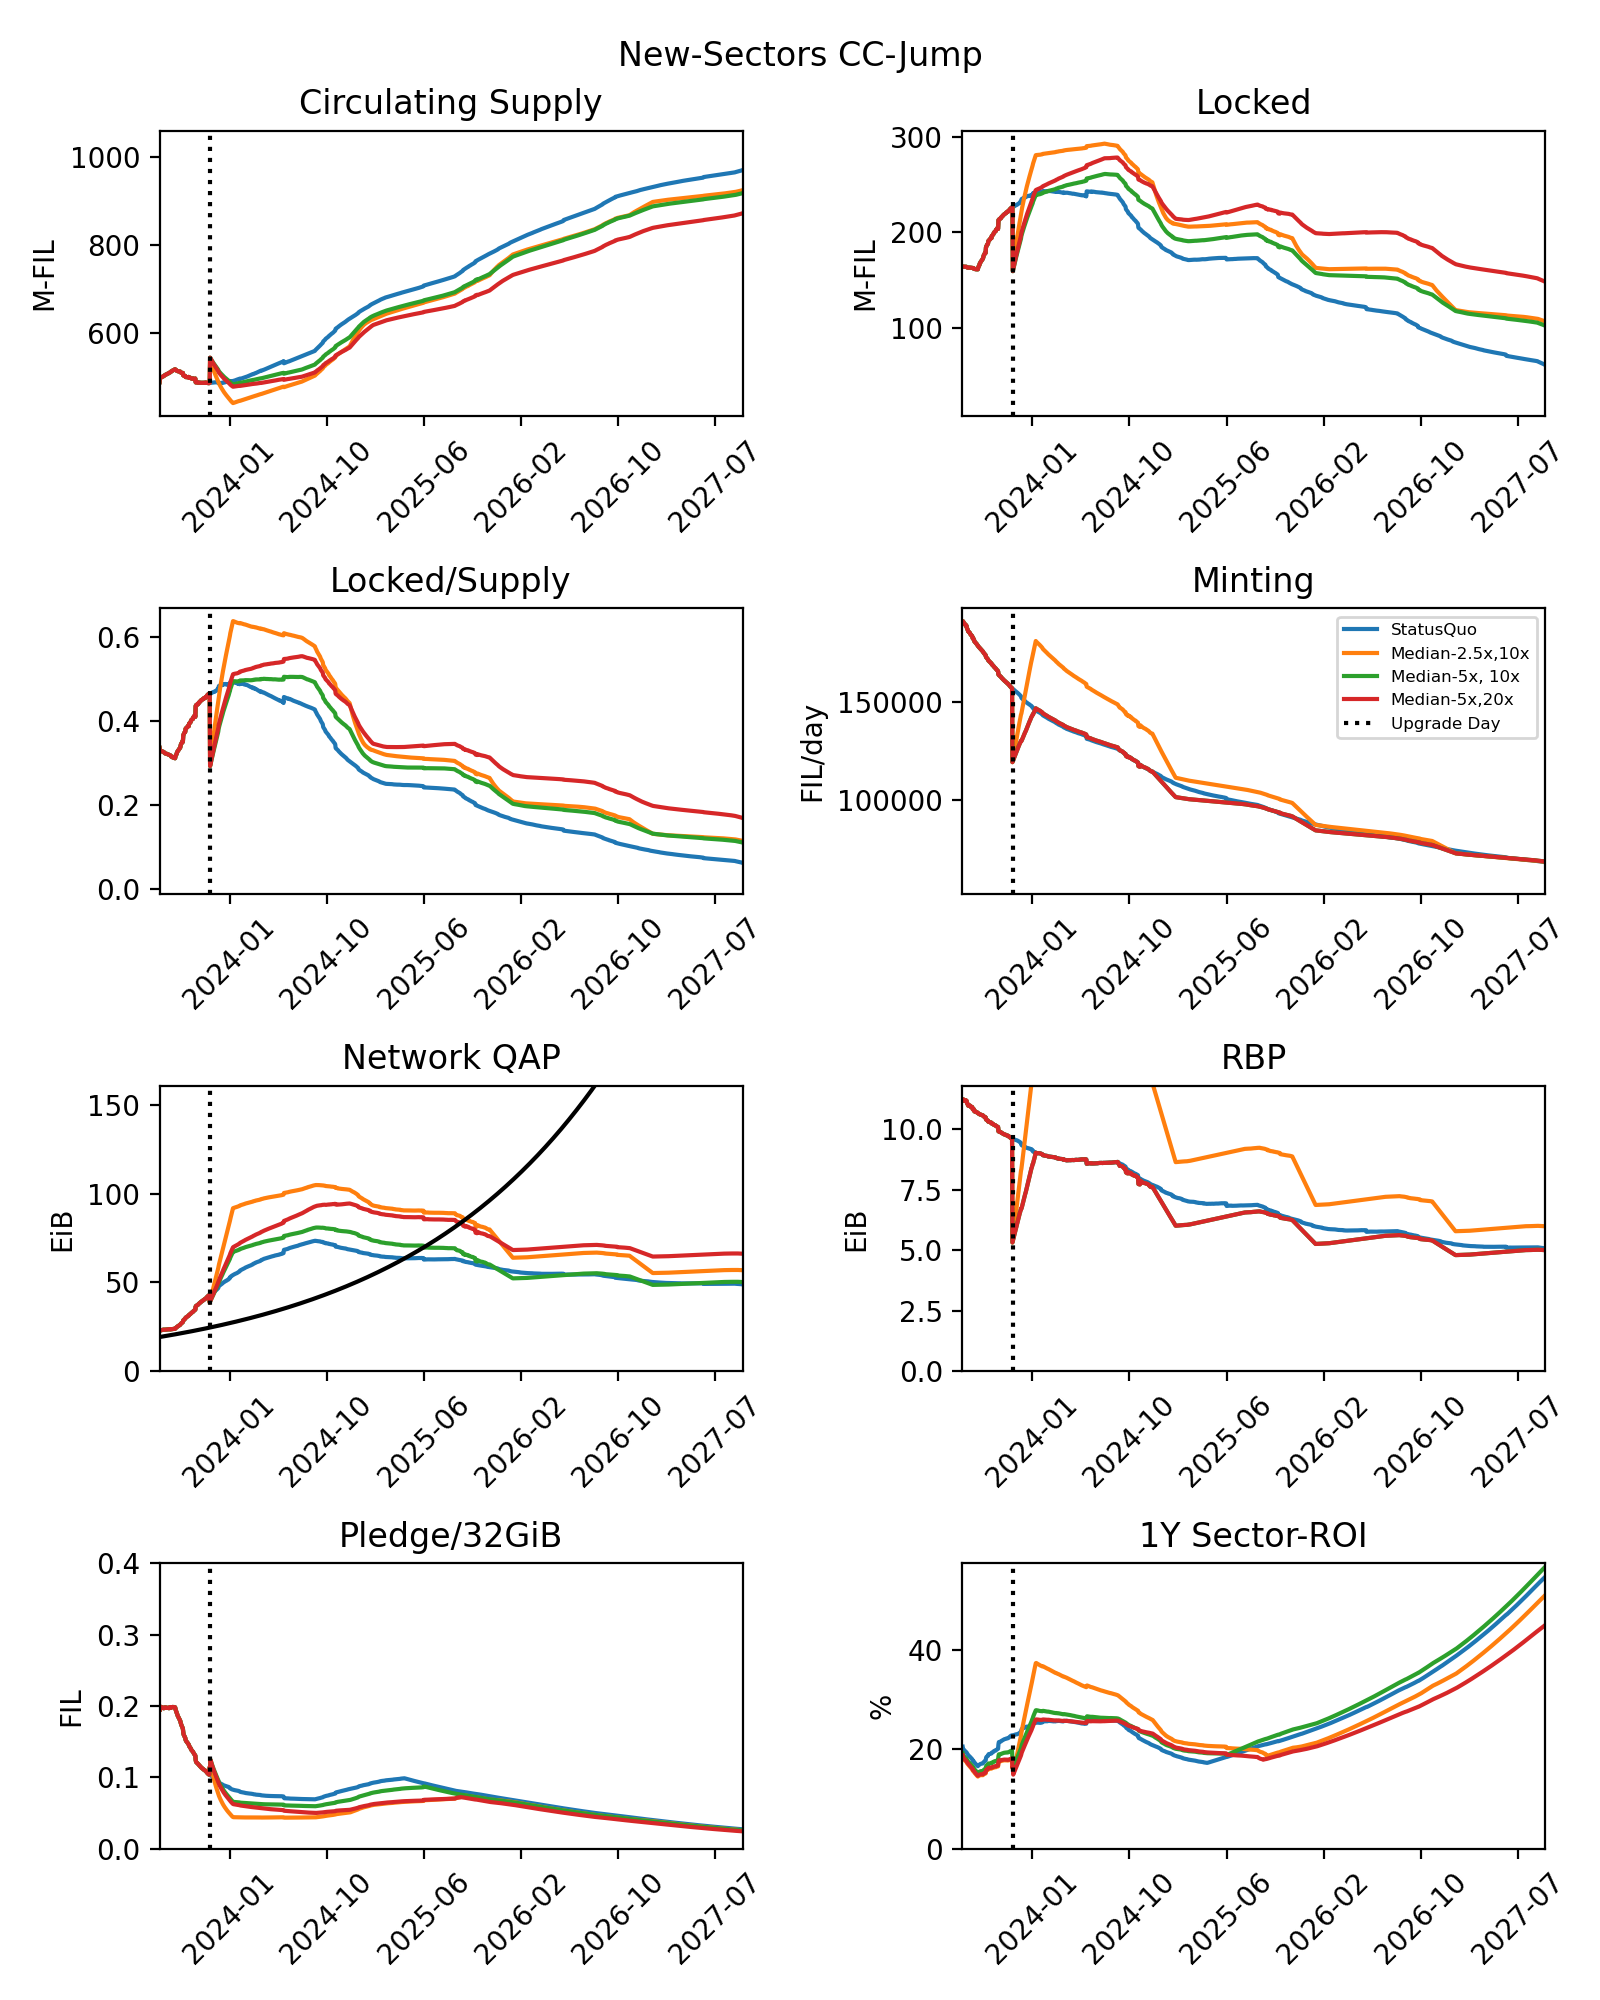

In [51]:
# plot a different view, where we only show one of the four options, but across different power multipliers
plt_statusquo = True
multiplier_cfgs = [
    'Median-2.5x,10x',
    'Median-5x, 10x',
    'Median-5x,20x'
]
scenario_cfg = '2B'  # can be 1A, 1B, 2A, 2B.  Refer to the code to determine what each actually means


plt.figure(figsize=(8,10))
if plt_statusquo:
    no_sdm = results['StatusQuo[%s]' % (plt_cfg,)]['rbp_roi']

min_time = no_sdm['date'].iloc[0]
max_time = current_date + datetime.timedelta(days=365*4)
        
plt.subplot(4,2,1)
if plt_statusquo:
    p0, = plt.plot(no_sdm['date'], no_sdm['circ_supply'] / MEGA, label='StatusQuo')
for multiplier_cfg in multiplier_cfgs:
    res = results['%s[%s]' % (scenario_cfg,multiplier_cfg,)]['rbp_roi']
    plt.plot(res['date'], res['circ_supply'] / MEGA, label='%s' % (multiplier_cfg, ))
p5 = plt.axvline(intervention_date, linestyle=':', color='k', label='Upgrade Day')
plt.ylabel('M-FIL')
plt.title('Circulating Supply')

ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)


plt.subplot(4,2,2)
if plt_statusquo:
    plt.plot(no_sdm['date'], no_sdm['network_locked']/MEGA, label='StatusQuo')
for multiplier_cfg in multiplier_cfgs:
    res = results['%s[%s]' % (scenario_cfg,multiplier_cfg,)]['rbp_roi']
    plt.plot(res['date'], res['network_locked'] / MEGA, label='%s' % (multiplier_cfg, ))

plt.axvline(intervention_date, linestyle=':', color='k')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')
plt.title('Locked')
plt.ylabel('M-FIL')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)

plt.subplot(4,2,3)
if plt_statusquo:
    plt.plot(no_sdm['date'], (no_sdm['network_locked']/no_sdm['circ_supply']), label='StatusQuo')
for multiplier_cfg in multiplier_cfgs:
    res = results['%s[%s]' % (scenario_cfg,multiplier_cfg,)]['rbp_roi']
    plt.plot(res['date'], res['network_locked'] / res['circ_supply'], label='%s' % (multiplier_cfg, ))

plt.axvline(intervention_date, linestyle=':', color='k')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')
plt.title('Locked/Supply')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)

k = 'day_network_reward'; scale=1; ylab_str='FIL/day'; title_str='Minting'
plt.subplot(4,2,4)
if plt_statusquo:
    plt.plot(no_sdm['date'], no_sdm[k]/scale, label='StatusQuo')
for multiplier_cfg in multiplier_cfgs:
    res = results['%s[%s]' % (scenario_cfg,multiplier_cfg,)]['rbp_roi']
    plt.plot(res['date'], res[k] / scale, label='%s' % (multiplier_cfg, ))

plt.axvline(intervention_date, linestyle=':', color='k', label='Upgrade Day')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')
plt.title(title_str)
plt.ylabel(ylab_str)
plt.legend(fontsize=6)
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)

plt.subplot(4,2,5)
if plt_statusquo:
    plt.plot(no_sdm['date'], no_sdm['network_QAP'] / EIB, label='StatusQuo')
for multiplier_cfg in multiplier_cfgs:
    res = results['%s[%s]' % (scenario_cfg,multiplier_cfg,)]['rbp_roi']
    plt.plot(res['date'], res['network_QAP']/EIB, label='%s' % (multiplier_cfg, ))

plt.axvline(intervention_date, linestyle=':', color='k')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')
plt.title('Network QAP')
plt.ylabel('EiB')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)
max_qap = np.max([no_sdm[no_sdm['date']<=max_time]['network_QAP'],
                  r1a[r1a['date']<=max_time]['network_QAP'],
                  r2a[r2a['date']<=max_time]['network_QAP'],
                  r1b[r1b['date']<=max_time]['network_QAP'],
                  r2b[r2b['date']<=max_time]['network_QAP']])
max_qap_eib = max_qap / EIB
plt.ylim(0, max_qap_eib*1.05)
# plt.legend(fontsize=8)
baseline = baseline_storage(no_sdm.days * EPOCH_PER_DAY)
plt.plot(no_sdm['date'], baseline, color='k')


k = 'network_RBP'; title_str='RBP'; scale=EIB; ylab_str = 'EiB'
plt.subplot(4,2,6)
if plt_statusquo:
    plt.plot(no_sdm['date'], no_sdm[k]/scale, label='StatusQuo')
for multiplier_cfg in multiplier_cfgs:
    res = results['%s[%s]' % (scenario_cfg,multiplier_cfg,)]['rbp_roi']
    plt.plot(res['date'], res[k]/scale, label='%s' % (multiplier_cfg, ))

plt.axvline(intervention_date, linestyle=':', color='k')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')

plt.title(title_str)
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)
max_v = np.concatenate([no_sdm[no_sdm['date']<=max_time][k].values,
                r1a[r1a['date']<=max_time][k].values,
                r2a[r2a['date']<=max_time][k].values,
                r1b[r1b['date']<=max_time][k].values,
                r2b[r2b['date']<=max_time][k].values])
mv = np.nanmax(max_v[max_v != np.inf])
plt.ylim(0, mv*1.05/scale)
plt.ylabel(ylab_str)

plt.subplot(4,2,7)
k='day_pledge_per_QAP'
if plt_statusquo:
    plt.plot(no_sdm['date'].iloc[1:], no_sdm[k].iloc[1:], label='StatusQuo')
for multiplier_cfg in multiplier_cfgs:
    res = results['%s[%s]' % (scenario_cfg,multiplier_cfg,)]['rbp_roi']
    plt.plot(res['date'].iloc[1:], res[k].iloc[1:], label='%s' % (multiplier_cfg, ))

plt.axvline(intervention_date, linestyle=':', color='k')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')
plt.title('Pledge/32GiB')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)
max_v = np.concatenate([no_sdm[no_sdm['date']<=max_time][k].values,
                r1a[r1a['date']<=max_time][k].values,
                r2a[r2a['date']<=max_time][k].values,
                r1b[r1b['date']<=max_time][k].values,
                r2b[r2b['date']<=max_time][k].values])
mv = np.nanmax(max_v[max_v != np.inf])
plt.ylim(0, 0.4)
plt.ylabel('FIL')

plt.subplot(4,2,8)
if plt_statusquo:
    plt.plot(no_sdm['date'], no_sdm['1y_sector_roi']*100)
for multiplier_cfg in multiplier_cfgs:
    res = results['%s[%s]' % (scenario_cfg,multiplier_cfg,)]['rbp_roi']
    plt.plot(res['date'], res['1y_sector_roi']*100, label='%s' % (multiplier_cfg, ))

plt.axvline(intervention_date, linestyle=':', color='k')
# plt.axvline(intervention_date+datetime.timedelta(days=360), linestyle=':', color='k')

plt.title('1Y Sector-ROI')
plt.ylabel('%')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)
max_v = np.concatenate([no_sdm[no_sdm['date']<=max_time]['1y_sector_roi'].values,
                r1a[r1a['date']<=max_time]['1y_sector_roi'].values,
                r2a[r2a['date']<=max_time]['1y_sector_roi'].values,
                r1b[r1b['date']<=max_time]['1y_sector_roi'].values,
                r2b[r2b['date']<=max_time]['1y_sector_roi'].values])
mv = np.nanmax(max_v[max_v != np.inf])
plt.ylim(0, mv*1.05*100)

plt.suptitle('%s' % (scenariocfg2str[scenario_cfg],))
plt.tight_layout()
plt.savefig(os.path.join(results_folder, 'macro_%s.png' % (scenariocfg2str[scenario_cfg],)))